In [27]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import MinMaxScaler
import operator

from sklearn.cluster import KMeans
import mahotas as mt


# Loading the Dataset

In [28]:
file_path = 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories'
folder_names = []
folder_names = [f for f in sorted(os.listdir(file_path))]

print(len(folder_names))  # 102 = 101 categories + background


102


C:\Users\Joe\AppData\Local\Temp\ipykernel_9268\2155978937.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


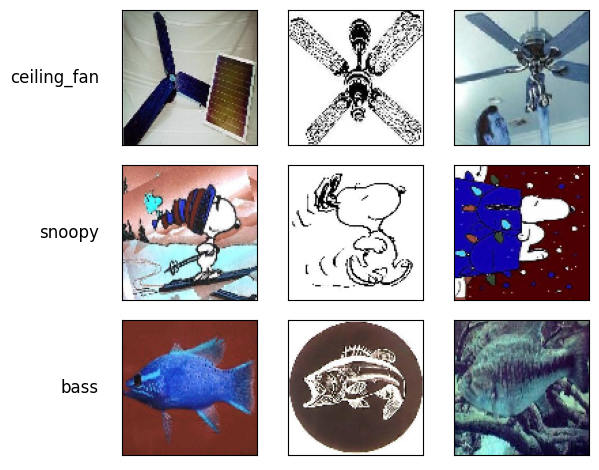

In [29]:
num_categories = 3
num_imgs = 3 
selected_categories = np.random.randint(0,101, num_categories, dtype="I")

fig, ax = plt.subplots(nrows=num_categories, ncols=num_imgs)

fig.subplots_adjust(wspace=0.1,hspace=0.1)

for a, cat in enumerate(selected_categories):
    folder_path = file_path + '/' + folder_names[cat]
    image_names = [a for a in sorted(
        os.listdir(folder_path))][:num_imgs]
    
    for b, img_name in enumerate(image_names):
        img_path = folder_path + '/' + img_name
        img = cv2.imread(img_path)
        img = cv2.resize(img, (100, 100))
        ax[a, b].imshow(img)
        ax[a, b].set_xticks([])
        ax[a, b].set_yticks([])
        
        if b == 0:
            pad = 5  # in points
            #ax[i,j].set_ylabel(folder_names[category], rotation=0, size='large')
            ax[a,b].annotate(folder_names[cat], xy=(0, 0.5), xytext=(-ax[a,b].yaxis.labelpad - pad, 0),
                xycoords=ax[a,b].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        
fig.tight_layout()
#plt.axis('off')
fig.show()


In [30]:
img_data = []
img_money = []
num_categories = 6
num_imgs = 9
selected_categories = np.random.randint(0,101, num_categories, dtype="I")

for a, cat in enumerate(selected_categories):
    folder_path = file_path + '/' + folder_names[cat]
    image_names = [a for a in sorted(
        os.listdir(folder_path))][:num_imgs]

    for b, img_name in enumerate(image_names):
        img_path = folder_path + '/' + img_name
        img_money.append(img_path)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (100, 100))
        
        if img is not None:
            img_data.append(img)
       


# Global Functions

In [31]:
def normalise(distances, scale):
    scaler = MinMaxScaler((0, scale))
    keys = distances.keys()
    distances = np.array(list(distances.values()))
    distances = scaler.fit_transform(distances.reshape(-1, 1))
    distances = dict(zip(keys, distances))
    return distances

# Histogram features

In [32]:
def histogram_features(img):
    features = [] 
    pp_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    channels = cv2.split(pp_img)
    channel_names = ('h', 's', 'v')
    for (channel, channel_name) in zip(channels, channel_names):
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        features.extend(hist.flatten())
        return features

In [33]:
def hist_features_database(data_imgs):
    db_features = []
    for img in data_imgs:
        db_features.append(histogram_features(img))
    db_hist_df = DataFrame(db_features)
    return db_hist_df

In [34]:
def calc_hist_distance(query_img, db_df):
    feature_vectors = db_df.values.tolist()
    distances = {}
    for a in range(len(feature_vectors)):
        query_features = histogram_features(query_img)
        dist = euclidean(query_features, feature_vectors[a])
        distances[a] = dist
    return normalise(distances, 20)

# Gabor Features

In [35]:
def build_filters():
    filters = []
    kernal_size = 9 
    for theta in np.arange(0, np.pi, np.pi / 8):
        for deg in np.arange(0, 6*np.pi/4, np.pi / 4):
            kernal = cv2.getGaborKernel((kernal_size, kernal_size), 1.0, theta, deg, 0.5, 0, ktype= cv2.CV_32F)
            kernal /= 1.5 * kernal.sum()
            filters.append(kernal)
    return filters

In [36]:
def convolve_filters(img, filters):
    conv = np.zeros_like(img)
    for kernal in filters:
        filter_img = cv2.filter2D(img, cv2.CV_8UC3, kernal)
        np.maximum(conv, filter_img, conv)
    return conv

In [37]:
def gabor_features(img):
    features = []
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    filters = np.asarray(build_filters())
    
    for a in range(20):
        energy = 0
        conv = convolve_filters(img, filters[a])
        for b in range(100):
            for c in range(100):
                energy += conv[b][c] * conv[b][c]
        features.append(energy)
    for a in range(20):
        mean = 0
        conv = convolve_filters(img, filters[a])
        for b in range(100):
            for c in range(100):
                mean += abs(conv[a][b])
        features.append(mean)
    features = np.array(features)
    return features

In [38]:
filters = np.asarray(build_filters())
test = convolve_filters(img, filters[20])


In [39]:
np.shape(test)


(100, 100, 3)

In [40]:
def gabor_features_database(data_imgs):
    db_feat = []
    for img in data_imgs:
        db_feat.append(gabor_features(img))
    db_gabor_df = DataFrame(db_feat)
    return db_gabor_df

In [41]:
def calc_gabor_distance(query_img, db_df):
    distances = {}
    query_feat = gabor_features(query_img)
    feature_vector = db_df.values.tolist()
    
    for a in range(len(feature_vector)):
        distances[a] = euclidean(query_feat, feature_vector[a])
    distances = normalise(distances, 20)
    return distances

# Haralick Feature Testing

In [42]:
def haralick_features(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    texture = mt.features.haralick(img)
    features = texture.mean(axis=0)
    return features

In [43]:
def haralick_features_database(img_db):
    features = []
    for img in img_db:
        feat = haralick_features(img)
        features.append(feat)
    haralick_df = DataFrame(features)
    return haralick_df


In [44]:
def calc_haralick_distance(query_img, db_df):
    distances = {}
    query_feat = haralick_features(query_img)
    haralick_fv = db_df.values.tolist()
    for a in range(len(haralick_fv)):
        img_feats = haralick_fv[a]
        dist = euclidean(query_feat, img_feats)
        distances[a] = dist
    distances = normalise(distances, 20)
    return distances

# Distance Metric Calculation

In [45]:
def calc_distances_total(hist_dist, gabor_dist):
    total_dist = []
    hist_weight = 0.8
    gabor_weight = 0.2
    
    for a in hist_dist:
        hist_dist[a] *= hist_weight
        gabor_dist[a] *= gabor_weight
        total_dist.append(hist_dist[a] + gabor_dist[a])  
    return sorted(dict(zip(np.arange(0, len(img_data)), (np.array(total_dist)))).items(), key=operator.itemgetter(1))


In [46]:
query_img = img_data[0]

hist_dist = calc_hist_distance(query_img, hist_features_database(img_data))
gabor_dist = calc_gabor_distance(query_img, gabor_features_database(img_data))

final_dist = calc_distances_total(hist_dist, gabor_dist)

C:\Users\Joe\AppData\Local\Temp\ipykernel_9268\1623920403.py:11: RuntimeWarning: overflow encountered in ubyte_scalars
  energy += conv[b][c] * conv[b][c]


# Model 2 Testing

# HOG

In [47]:
import skimage
from skimage.feature import hog

In [48]:
def HOG_features(img, bin_n, normalise = True):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    fd = hog(img, orientations=8, pixels_per_cell=(2,2), cells_per_block=(1,1))
    b = np.linspace(0, np.max(fd), bin_n+1)
    histogram, _ = np.histogram(fd, bins=b)
    
    if normalise:
        histogram = np.array(histogram) / np.sum(histogram)
    
    return histogram


In [54]:
def HOG_hist(img, type_h, bin_n, slice_n, norm):
    
    if type_h == 'global':
        histogram = HOG_features(img, bin_n)
        
    elif type_h == 'reigon':
        histogram = np.zeros((slice_n, slice_n, bin_n))
        slice_h = np.around(np.linspace(0, img.shape[0], slice_n +1)).astype(int)
        slice_w = np.around(np.linspace(0, img.shape[1], slice_n + 1)).astype(int)
        
        for h in range(len(slice_h)-1):
            for w in range(len(slice_w)-1):
                #create reigons for image
                reigon = img[slice_h[h]:slice_h[h+1], slice_w[w]: slice_w[w+1]]
                histogram[h][w] = HOG_features(reigon, bin_n)
        
    if normalise:
        histogram /= np.sum(histogram)
            
    return histogram.flatten()


In [55]:
test77 = HOG_hist(img, "reigon", 10, 6, False)


# Colour Features

In [81]:
import itertools
import imageio.v3 as iio


In [87]:
def colour_features(img, bin_n, bins, c):
    temp_img = img.copy()
    bins_i = {key: ind for ind, key in enumerate(itertools.product(np.arange(bin_n), repeat=c))}
    histogram = np.zeros(bin_n ** c)
    
    #cluster pixels
    for a in range(len(bins)-1):
        temp_img[(img >= bins[a]) & (img < bins[a+1])] = a
        
    for h in range(temp_img.shape[0]):
        for w in range(temp_img.shape[1]):
            ind_b = bins_i[tuple(temp_img[h,w])]
            histogram[ind_b] += 1
    return histogram

In [98]:
def colour_hist(img, type_h, bin_n, slice_n, norm):
    bins = np.linspace(0, 256, bin_n+1, endpoint=True)
    h,w,c = img.shape
    if type_h == 'global':
        histogram = colour_features(img, bin_n, bins, c)
        
    elif type_h == 'reigon':
        histogram = np.zeros((slice_n, slice_n, bin_n ** c))
        slice_h = np.around(np.linspace(
            0, img.shape[0], slice_n + 1)).astype(int)
        slice_w = np.around(np.linspace(
            0, img.shape[1], slice_n + 1)).astype(int)
        
        for h in range(len(slice_h)-1):
            for w in range(len(slice_w)-1):
                #create reigons for image
                reigon = img[slice_h[h]:slice_h[h+1], slice_w[w]: slice_w[w+1]]
                histogram[h][w] = colour_features(reigon, bin_n, bins, c)
                
        if norm:
            histogram /= np.sum(histogram)
        
    return histogram.flatten()


In [99]:
test22 = colour_hist(img, 'reigon', 12,3, True)
